# Qualitative sensitivity analysis

We showcase the use of `econsa` for qualitative sensitivity analysis.

In [3]:
# from temfpy.uncertainty_quantification import simple_linear_function,
from morris import elementary_effects  # noqa: F401
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

The module `morris` implements the extended Morris method as proposed by Ge & Menendez (2017). They extend the Morris method in the sense, that their algorithm takes dependency among inputs into account.

For illustration purposes consider the Morris method for independent inputs only.

Let $x = \{x_1, \dots, x_k\}$ denote a sample of values assigned to the $X_i$'s. $f(x)$ is then the model output obtained for the values in $x$. Now consider a second sample $x_{\Delta_i} = \{x_1, \dots, x_{i-1}, x_i + \Delta, x_{i+1}, \dots, x_k\}$ that is identical to $x$ up to input $x_i$ which is varied by $\Delta$. Then, one elementary effect for input $i$ is derived by

$$EE_i = \frac{f(x_{\Delta_i}) - f(x)}{\Delta}.$$


The above elementary effect is computed $N$ times, each for a varying $\Delta$. The actual sensitivity measures resulting from the Morris method are the mean, denoted by $\mu^\ast_i$, and the standard deviation, denoted by $\sigma_i$, taken from the $N$ elementary effects per input $i$.

$$\mu_i^\ast = \frac{1}{N} \sum_{r=1}^N \vert EE_{i, r} \vert$$

$$\sigma_i = \sqrt{\frac{1}{N-1} \sum_{r=1}^N (EE_{i, r} - \mu_i)^2}$$

The derivation of the extended Morris indices is more complicated and we get *four* sensitivity indices indstead of only two: *independent* and *full* Morris indices, $(\mu_i^{\ast,\ ind}, \mu_i^{\ast,\ full}, \sigma_i^{ind}, \sigma_i^{full})$, which are computed analogously to the Morris indices under input independence, but are based on different elementary effects:

- $EE_i^{ind}$ denotes *independent* elementary effects for input $i$, effects that exclude the contributions attributable to the dependence between input $X_i$ and $X_j$ for $i \neq j$, and

- $EE_i^{full}$ denotes *full* elementary effects for input $i$, that include the effects due to correlation with other inputs.

The implementation of the algorithm used in `econsa` uses the *radial design* and the *inverse Nataf transformation* as described in Ge & Menendez (2017).

For applying the Morris method, we need to specify the following arguments:

- `func`: The model for which we want to calculate the Morris indices. Note how the data needs to be accessed within the function. See below example.

- `params`: The mean values of the inputs.

- `cov`: The variance-covariance matrix of the inputs.

- `n_draws`: Number of draws, which corresponds to $N$ above.

Note that the current implementation of the Morris method in `econsa` does allow for Gaussian (i.e. normally distributed) inputs only.

## The `func` argument
`func` is the implementation of the model we want to conduct sensitivity analysis for. The Morris method can be applied to all models that return a unique value for a given set of realisations of the model inputs.

The model implemented by `func` needs to access the inputs in the following way, if the input names are specified in `params` and `cov`:

`m = x["value"]["m"]`

`c = x["value"]["c"]`

`s = x["value"]["s"]`.

Alternatively we can access them via the index as well:

`m = x["value"][0]`

`c = x["value"][1]`

`s = x["value"][2]`.

In [4]:
def eoq_model_morris(x, r=0.1):
    """EOQ Model that accesses data as expected by elementary_effects."""
    m = x["value"]["m"]
    c = x["value"]["c"]
    s = x["value"]["s"]

    # Need to ensure that there exists a solution (i.e. no NaNs).
    if m < 0:
        m = 0
    elif c < 0:
        raise ValueError
    elif s < 0:
        s = 0
    else:
        pass

    return np.sqrt((24 * m * s) / (r * c))

## The `params` and `cov` arguments
Specify the input names in the data frames `params` and `cov` to display the input names in the output of `elementary_effects`. `params` is a vector of means of the normally distributed model inputs. `params` needs to be a `pandas.DataFrame` with a colum called `"value"`, which contains the means of the inputs.

`cov` is the corresponding variance-covariance matrix. The variance-covariance matrix describes the dependence structure of the inputs. As `params`, `cov` needs to be a `pandas.DataFrame`. Indices need to be the same as in `params`.

In [5]:
names = ['m', 'c', 's']
params = pd.DataFrame(data=np.array([5.345, 0.0135, 2.15]), columns=['value'], index=names)
cov = pd.DataFrame(data=np.diag([1, 0.000001, 0.01]), columns=names, index=names)

### The `n_draws` argument
`n_draws` is the number of elementary effects we want to use for the  computation of the Morris indices. The total computational cost of the extended Morris method amounts to $3kN$, where $k$ denotes the number of inputs and $N$ the number of draws (`n_draws`).

In [6]:
n_draws = 100

### The `n_cores` argument
Parallelising code is done by the Python built-in `multiprocessing` module, where `n_cores` is the number of cores employed. The default is that that `n_cores` is set to $1$.

In [7]:
results = elementary_effects(eoq_model_morris, params, cov, n_draws)

### The output
The output of `elementary_effects` is a dictionary containing the four sensitivity indices derived from the `n_draws` elementary effects: $(\mu_i^{\ast,\ ind}, \mu_i^{\ast,\ full}, \sigma_i^{ind}, \sigma_i^{full})$. The Morris indices are accessed as shown below.

#### Independent Morris indices $(\mu_i^{\ast,\ ind}, \sigma_i^{ind})$

In [8]:
morris_ind = pd.DataFrame(pd.concat((results['mu_ind'], results['sigma_ind']), axis=1))
morris_ind.columns = ['mu', 'sigma']
morris_ind

,mu,sigma
m,152.932694,54.844400
c,57.953365,17.314969
s,33.104776,7.963128


#### Full Morris indices $(\mu_i^{\ast,\ full}, \sigma_i^{full})$

In [9]:
morris_full = pd.DataFrame(pd.concat((results['mu_corr'], results['sigma_corr']), axis=1))
morris_full.columns = ['mu', 'sigma']
morris_full

,mu,sigma
m,2369.122666,2523.492389
c,3270.066313,8210.375153
s,2888.326540,3814.720109


### Plotting the results
The input ranking is conducted based on $(\mu_i^{\ast,\ ind}, \mu_i^{\ast,\ full})$.

In [16]:
def plot_morris_indices(morris_full, morris_ind):
    fig, ax = plt.subplots(2, 1)
    sns.set_style("whitegrid")

    sns.scatterplot(x=morris_full['mu'], y=morris_full['sigma'], data=morris_full, ax=ax[0])
    sns.scatterplot(x=morris_ind['mu'], y=morris_ind['sigma'], data=morris_full, ax=ax[1])

    ax[0].set_title('Full Morris indices')

    ax[0].text(x=morris_full['mu'].iloc[0] + 20, y=morris_full['sigma'].iloc[0], s='m')
    ax[0].text(x=morris_full['mu'].iloc[1] + 20, y=morris_full['sigma'].iloc[1], s='c')
    ax[0].text(x=morris_full['mu'].iloc[2] + 20, y=morris_full['sigma'].iloc[2], s='s')

    ax[1].set_title('Independent Morris indices')

    ax[1].text(x=morris_ind['mu'].iloc[0] + 2, y=morris_ind['sigma'].iloc[0], s='m')
    ax[1].text(x=morris_ind['mu'].iloc[1] + 2, y=morris_ind['sigma'].iloc[1], s='c')
    ax[1].text(x=morris_ind['mu'].iloc[2] + 2, y=morris_ind['sigma'].iloc[2], s='s')

    plt.tight_layout()
    plt.show()

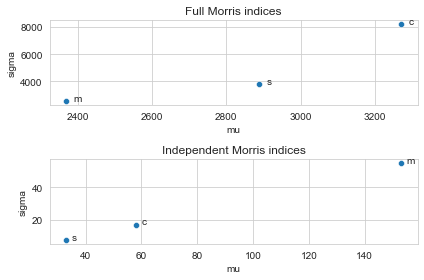

In [17]:
plot_morris_indices(morris_full, morris_ind)

### Interpretation
The input ranking based on $(\mu_i^{\ast,\ ind}, \mu_i^{\ast,\ full})$ differs when independent or full indices are considered.

The ranking in ascending order according to *full* indices is $c - s - m$, whereas the ranking based on *independent* inidces is $m - c - s$. For input $m$ this means that the variance contribution due to the isolated effect of $m$ is much larger than the contribution due to dependence with other inputs. Inputs $c$ and $s$, though, exhibit large effects due to dependence.

Since none of the inputs is close to zero, we can conclude that all three inputs are important in terms of their output variance contribution.